In [34]:
import gpxpy
import gpxpy.gpx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from folium.vector_layers import Rectangle
from shapely.geometry import LineString
from shapely.ops import unary_union
from shapely.geometry import Point
import pandas as pd
from math import exp, sqrt, pi
import networkx as nx
from shapely.geometry import LineString, Point
from geopy.distance import geodesic, great_circle

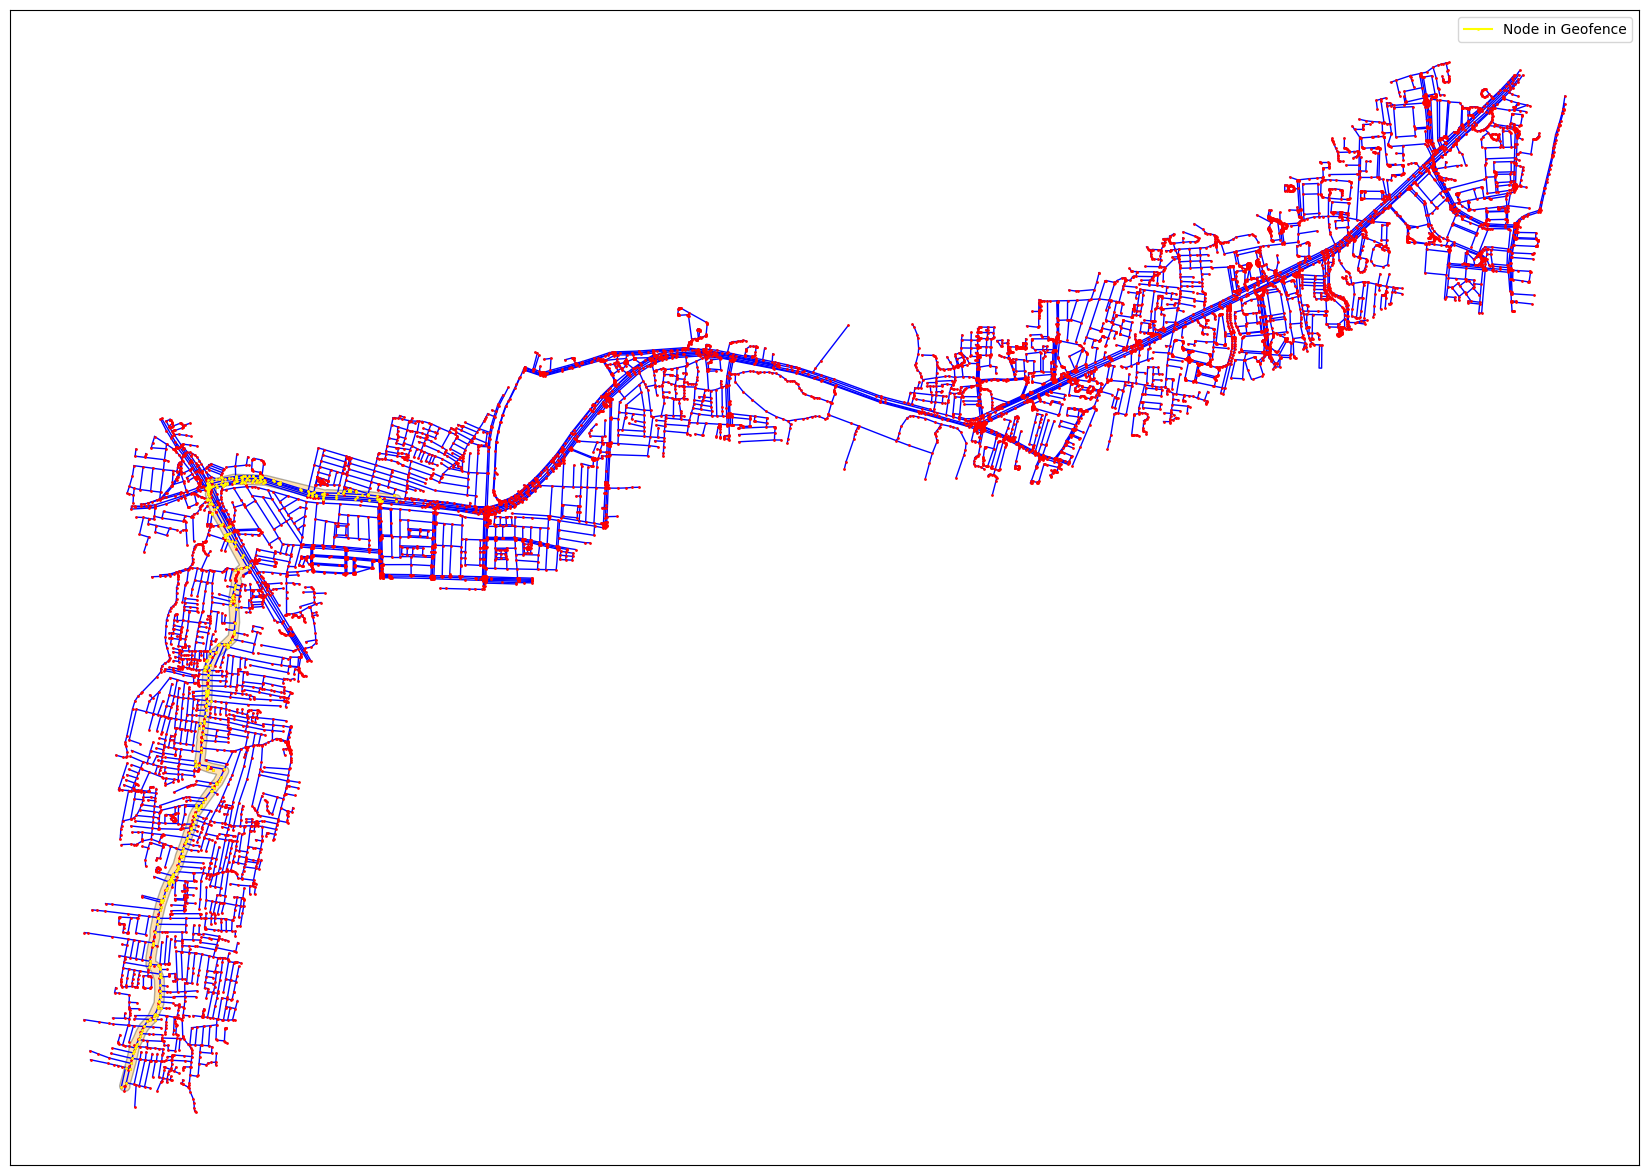

371
[(77.6228281, 12.9173744), (77.6300028, 12.9169035), (77.628382, 12.917033), (77.6228925, 12.9171404), (77.6240446, 12.9151188), (77.6239418, 12.9150658), (77.6233472, 12.9161431), (77.6227896, 12.9171082), (77.6227353, 12.9171967), (77.6224637, 12.9032018), (77.6221459, 12.9022391), (77.622168, 12.902339), (77.6223827, 12.9022951), (77.6228324, 12.9022167), (77.6237565, 12.9020556), (77.6226375, 12.9046252), (77.6224649, 12.9029845), (77.6244258, 12.9106968), (77.6292164, 12.9166941), (77.6292106, 12.9166108), (77.6228789, 12.9071072), (77.622868, 12.9065383), (77.6200391, 12.8888505), (77.6199368, 12.8888902), (77.6286947, 12.9169488), (77.6302894, 12.9168895), (77.6316951, 12.9168783), (77.6183449, 12.8851927), (77.6186611, 12.8864994), (77.622393, 12.9000179), (77.6222005, 12.900042), (77.6222042, 12.9001206), (77.6224445, 12.9001022), (77.6185295, 12.8859558), (77.6185973, 12.8862356), (77.6187428, 12.8867907), (77.6187711, 12.8868915), (77.6188321, 12.8870555), (77.6188723, 1

In [41]:
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic

fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
data = gpd.read_file(fp)

G = nx.Graph()

for line in data.geometry:
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        length = line.length
        G.add_node(tuple(start.coords[0]), pos=tuple(start.coords[0]))
        G.add_node(tuple(end.coords[0]), pos=tuple(end.coords[0]))
        G.add_edge(tuple(start.coords[0]), tuple(end.coords[0]), geometry=line)

gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'
with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index_1 = 0
end_index_1 = 150
observations_1 = []

for track in gpx.tracks:
    for segment in track.segments:
        for i, point in enumerate(segment.points):
            if start_index_1 <= i < end_index_1:
                observations_1.append((point.longitude, point.latitude))
                
observations_1_no_duplicates = []
for i, point in enumerate(observations_1):
    if i == 0 or point != observations_1[i - 1]:
        observations_1_no_duplicates.append(point)

gpx_path = LineString(observations_1_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
gpx_gdf = gpx_gdf.to_crs(epsg=3857)

geofence = gpx_gdf.buffer(30)
geofence = geofence.to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if len(connected_components) > 0:
    subgraph_1 = G.subgraph(connected_components[0]).copy()
    pos_1 = nx.get_node_attributes(subgraph_1, 'pos')

    states_in_geofence_1 = []
    for node, position in pos_1.items():
        point = Point(position)
        if geofence.geometry[0].contains(point):
            states_in_geofence_1.append(position)

    fig, ax = plt.subplots(figsize=(30, 15))

    for edge in subgraph_1.edges(data=True):
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    nx.draw_networkx_nodes(subgraph_1, pos_1, ax=ax, node_size=1, node_color='red')

    for point in observations_1_no_duplicates:
        ax.plot(point[0], point[1], marker='o', color='red', markersize=1)

    geofence.plot(ax=ax, color='orange', alpha=0.3, edgecolor='black')

    for node in states_in_geofence_1:
        ax.plot(node[0], node[1], marker='o', color='yellow', markersize=1, label="Node in Geofence")


    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:1], labels[:1])

    plt.show()
    print(len(states_in_geofence_1))
    print(states_in_geofence_1)

def calculate_geodesic_distance(points):
    total_distance = 0.0
    for i in range(1, len(points)):
        total_distance += geodesic(points[i-1], points[i]).kilometers
    return total_distance

total_geodesic_distance_km_1 = calculate_geodesic_distance(observations_1_no_duplicates)
print(f"Total geodesic distance of observation path: {total_geodesic_distance_km_1:.2f} km")

print(len(observations_1_no_duplicates))
print(observations_1_no_duplicates)

In [36]:
from geopy.distance import geodesic

observations_1_no_duplicates = []
for i, point in enumerate(observations_1):
    if i == 0 or point != observations_1[i - 1]:
        observations_1_no_duplicates.append(point)

def find_closest_nodes_with_distances(graph, observations):
    node_positions = nx.get_node_attributes(graph, 'pos')
    closest_nodes = []
    distances = []
    for obs in observations:
        closest_node = min(
            node_positions.keys(),
            key=lambda node: geodesic(obs, node_positions[node]).meters,
        )
        closest_distance = geodesic(obs, node_positions[closest_node]).meters
        closest_nodes.append(closest_node)
        distances.append(closest_distance)
    return closest_nodes, distances
closest_nodes_to_observations, distances_to_closest_nodes = find_closest_nodes_with_distances(G, observations_1_no_duplicates)
print("Closest nodes to observations:", closest_nodes_to_observations)
print("Distances to closest nodes (meters):", distances_to_closest_nodes)

Closest nodes to observations: [(77.6182356, 12.884756), (77.6182356, 12.884756), (77.6185295, 12.8859558), (77.6185295, 12.8859558), (77.6185973, 12.8862356), (77.6188321, 12.8870555), (77.6190344, 12.8875367), (77.6191444, 12.8878398), (77.6193169, 12.8882166), (77.6196305, 12.8885709), (77.6196781, 12.8885985), (77.620104, 12.8893053), (77.620211, 12.8901073), (77.620211, 12.8901073), (77.6202055, 12.890882), (77.6196777, 12.8915618), (77.6196777, 12.8915618), (77.6196454, 12.8917268), (77.619803, 12.8925879), (77.619803, 12.8925879), (77.619826, 12.8927133), (77.6199444, 12.8933031), (77.6199444, 12.8933031), (77.6199444, 12.8933031), (77.6200953, 12.8940356), (77.6201028, 12.8940732), (77.6202478, 12.8949056), (77.6205382, 12.8955536), (77.6206804, 12.8958963), (77.6208326, 12.896228), (77.621198, 12.8967676), (77.6212788, 12.8970939), (77.6213448, 12.89736), (77.621586, 12.8980894), (77.621787, 12.8986013), (77.6218927, 12.8988554), (77.6218927, 12.8988554), (77.6219122, 12.89889

In [44]:
# def swap_coordinates(array):
#     return [(lat, lon) for lon, lat in array]
# observations_1_swapped = swap_coordinates(observations_1_no_duplicates)
# states_in_geofence_1_swapped = swap_coordinates(states_in_geofence_1)
# closest_nodes_to_observations_swapped = swap_coordinates(closest_nodes_to_observations)
# print("observations_1_swapped:", observations_1_swapped)
# print("states_in_geofence_1_swapped:", states_in_geofence_1_swapped)
# print("closest_nodes_to_observations swapped:", closest_nodes_to_observations_swapped)

In [43]:
import numpy as np
import networkx as nx
from geopy.distance import geodesic, great_circle
import geopandas as gpd
from shapely.geometry import Point, LineString
import gpxpy
import matplotlib.pyplot as plt

def create_graph_from_shapefile(filepath):
    data = gpd.read_file(filepath)
    G = nx.Graph()
    for line in data.geometry:
        if line.geom_type == 'LineString':
            start, end = Point(line.coords[0]), Point(line.coords[-1])
            geodesic_distance = great_circle(start.coords[0], end.coords[0]).meters
            G.add_node(tuple(start.coords[0]), pos=tuple(start.coords[0]))
            G.add_node(tuple(end.coords[0]), pos=tuple(end.coords[0]))
            G.add_edge(
                tuple(start.coords[0]),
                tuple(end.coords[0]),
                geometry=line,
                weight=geodesic_distance,
            )
    return G

def calculate_graph_distances(graph, states):
    n_states = len(states)
    distances = np.zeros((n_states, n_states))
    for i in range(n_states):
        for j in range(n_states):
            if i != j:
                try:
                    path_length = nx.shortest_path_length(
                        graph,
                        source=tuple(states[i]),
                        target=tuple(states[j]),
                        weight="weight",
                    )
                    distances[i, j] = path_length
                except nx.NetworkXNoPath:
                    distances[i, j] = np.inf
    return distances

def calculate_beta_values(observations, closest_nodes_to_observations, state_distances_2):
    n_obs = len(observations)
    beta_values = []
    node_to_index = {node: idx for idx, node in enumerate(closest_nodes_to_observations)}
    for k in range(n_obs - 1): 
        node_1 = closest_nodes_to_observations[k]
        node_2 = closest_nodes_to_observations[k + 1]
        idx_1 = node_to_index[node_1]
        idx_2 = node_to_index[node_2]
        great_circle_distance = great_circle(observations[k], observations[k + 1]).meters
        route_distance = state_distances_2[idx_1, idx_2]
        diff_distance = abs(great_circle_distance - route_distance)
        beta_values.append(diff_distance)
    mediant_value = np.median(beta_values)
    beta = mediant_value / np.log(2)
    print(beta)
    return beta

def calculate_transition_matrix(states, zVec, observations, state_distances):
    n_states = len(states)
    n_obs = len(zVec)
    TRANS = np.zeros((n_states, n_states, n_obs))
    beta = calculate_beta_values(observations, closest_nodes_to_observations, state_distances)
    for k in range(n_obs):
        for i in range(n_states):
            for j in range(n_states):
                dij = abs(state_distances[i, j] - zVec[k])
                TRANS[i, j, k] = (1 / beta) * np.exp(-dij / beta)
        row_sums = np.sum(TRANS[:, :, k], axis=1)
        TRANS[:, :, k] = np.divide(TRANS[:, :, k], row_sums[:, None], where=row_sums[:, None] != 0)
    return TRANS

def calculate_emission_matrix(states, observations):
    n_states = len(states)
    n_obs = len(observations)
    distances = np.zeros((n_states, n_obs))
    for i in range(n_states):
        for j in range(n_obs):
            distances[i, j] = great_circle(states[i], observations[j]).m
    sigz = 1.4826 * np.median(distances_to_closest_nodes)
    EMIS = (1 / (np.sqrt(2 * np.pi) * sigz)) * np.exp(-0.5 * (distances / sigz) ** 2)
    print(sigz)
    return EMIS
global score

def viterbi_algorithm(states, observations, zVec, PRIOR, state_distances):
    n_states = len(states)
    T = len(observations)
    TRANS = calculate_transition_matrix(states, zVec, observations, state_distances)
    EMIS = calculate_emission_matrix(states, observations)
    global score
    score = np.zeros((n_states, T))
    pred = np.zeros((n_states, T), dtype=int)
    score[:, 0] = PRIOR * EMIS[:, 0]
    for t in range(1, T):
        temp_score = score[:, t - 1][:, None] * TRANS[:, :, t - 1]
        pred[:, t] = np.argmax(temp_score, axis=0)
        score[:, t] = np.max(temp_score, axis=0) * EMIS[:, t]
    IT = np.zeros(T, dtype=int)
    IT[-1] = np.argmax(score[:, -1]) 
    for t in range(T - 1, 0, -1):
        IT[t - 1] = pred[IT[t], t]
    return IT

def calculate_geodesic_distance(points):
    total_distance = 0.0
    for i in range(1, len(points)):
        total_distance += geodesic(points[i-1], points[i]).meters
    return total_distance

fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
data = gpd.read_file(fp)
G = create_graph_from_shapefile(fp)
gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'
with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
obs_1 = np.array(observations_1_no_duplicates)
s = np.array(states_in_geofence_1)
s_1 = np.array(closest_nodes_to_observations)
zVec_1 = [geodesic(obs_1[i], obs_1[i + 1]).meters for i in range(len(obs_1) - 1)]
state_distances = calculate_graph_distances(G, s)
state_distances_2 = calculate_graph_distances(G, s_1)
PRIOR_1 = np.ones(len(states_in_geofence_1)) / len(states_in_geofence_1)
matched_states_1 = viterbi_algorithm(states_in_geofence_1, obs_1, zVec_1, PRIOR_1, state_distances)
total_geodesic_distance_km_1 = calculate_geodesic_distance(observations_1_no_duplicates)
print(matched_states_1)

19.363936745493465
7.5517761775866425
[ 27  27  33  33  28  37  40  42  44  46  47  50  55  55  57  62  63  65
  66  66  67  68  68  68  70  71  73  77  80  83  88  90  91 118 122 120
 121 120 121 106 108 199 125 116 191  14  13 335  12  16   9   9 107 107
 107 107 107 109 110 110  15 164 164 126  21 171 154 290 290 134 160 163
 178 181 182 182 182 183 183 184 185 188 188 188 188 128 128 128 128 128
 129 129 129 130 131 131 101 206 206 204 204 204 208 141 311 311 311 311
 311 311 281 213 139 138  25 226 220 329 223]


In [45]:
matched_coordinates_1 = [states_in_geofence_1[state_idx] for state_idx in matched_states_1]

unique_matched_coordinates_1 = [
    coord for i, coord in enumerate(matched_coordinates_1)
    if i == 0 or coord != matched_coordinates_1[i - 1]
]

print(f"Number of unique matched coordinates: {len(unique_matched_coordinates_1)}")
for coord in unique_matched_coordinates_1:
    lon, lat = coord
    print(f"Latitude: {lat}, Longitude: {lon}")

print("\nAll matched coordinates:")
for coord in matched_coordinates_1:
    lon, lat = coord
    print(f"Latitude: {lat}, Longitude: {lon}")


Number of unique matched coordinates: 84
Latitude: 12.8851927, Longitude: 77.6183449
Latitude: 12.8859558, Longitude: 77.6185295
Latitude: 12.8864994, Longitude: 77.6186611
Latitude: 12.8870555, Longitude: 77.6188321
Latitude: 12.8875367, Longitude: 77.6190344
Latitude: 12.8878398, Longitude: 77.6191444
Latitude: 12.8882166, Longitude: 77.6193169
Latitude: 12.8885709, Longitude: 77.6196305
Latitude: 12.8885985, Longitude: 77.6196781
Latitude: 12.8893053, Longitude: 77.620104
Latitude: 12.8901073, Longitude: 77.620211
Latitude: 12.890882, Longitude: 77.6202055
Latitude: 12.8915166, Longitude: 77.6201067
Latitude: 12.8915618, Longitude: 77.6196777
Latitude: 12.8917268, Longitude: 77.6196454
Latitude: 12.8925879, Longitude: 77.619803
Latitude: 12.8927133, Longitude: 77.619826
Latitude: 12.8933031, Longitude: 77.6199444
Latitude: 12.8940356, Longitude: 77.6200953
Latitude: 12.8940732, Longitude: 77.6201028
Latitude: 12.8946598, Longitude: 77.6202453
Latitude: 12.8955536, Longitude: 77.6205


--- Path Segment Distances (Shortest Path Between Consecutive Matched States) ---
Segment from state 1219 to 1219: 0.00 meters
Segment from state 1219 to 2517: 27.54 meters
Segment from state 2517 to 2517: 0.00 meters
Segment from state 2517 to 1222: 19.63 meters
Segment from state 1222 to 3764: 23.32 meters
Segment from state 3764 to 3752: 25.38 meters
Segment from state 3752 to 3755: 14.36 meters
Segment from state 3755 to 2510: 21.60 meters
Segment from state 2510 to 3768: 36.17 meters
Segment from state 3768 to 3765: 5.36 meters
Segment from state 3765 to 1239: 50.96 meters
Segment from state 1239 to 1603: 23.92 meters
Segment from state 1603 to 1603: 0.00 meters
Segment from state 1603 to 7974: 18.56 meters
Segment from state 7974 to 1251: 22.58 meters
Segment from state 1251 to 1252: 47.91 meters
Segment from state 1252 to 1540: 8.52 meters
Segment from state 1540 to 7508: 27.10 meters
Segment from state 7508 to 7508: 0.00 meters
Segment from state 7508 to 1566: 3.95 meters
Segm

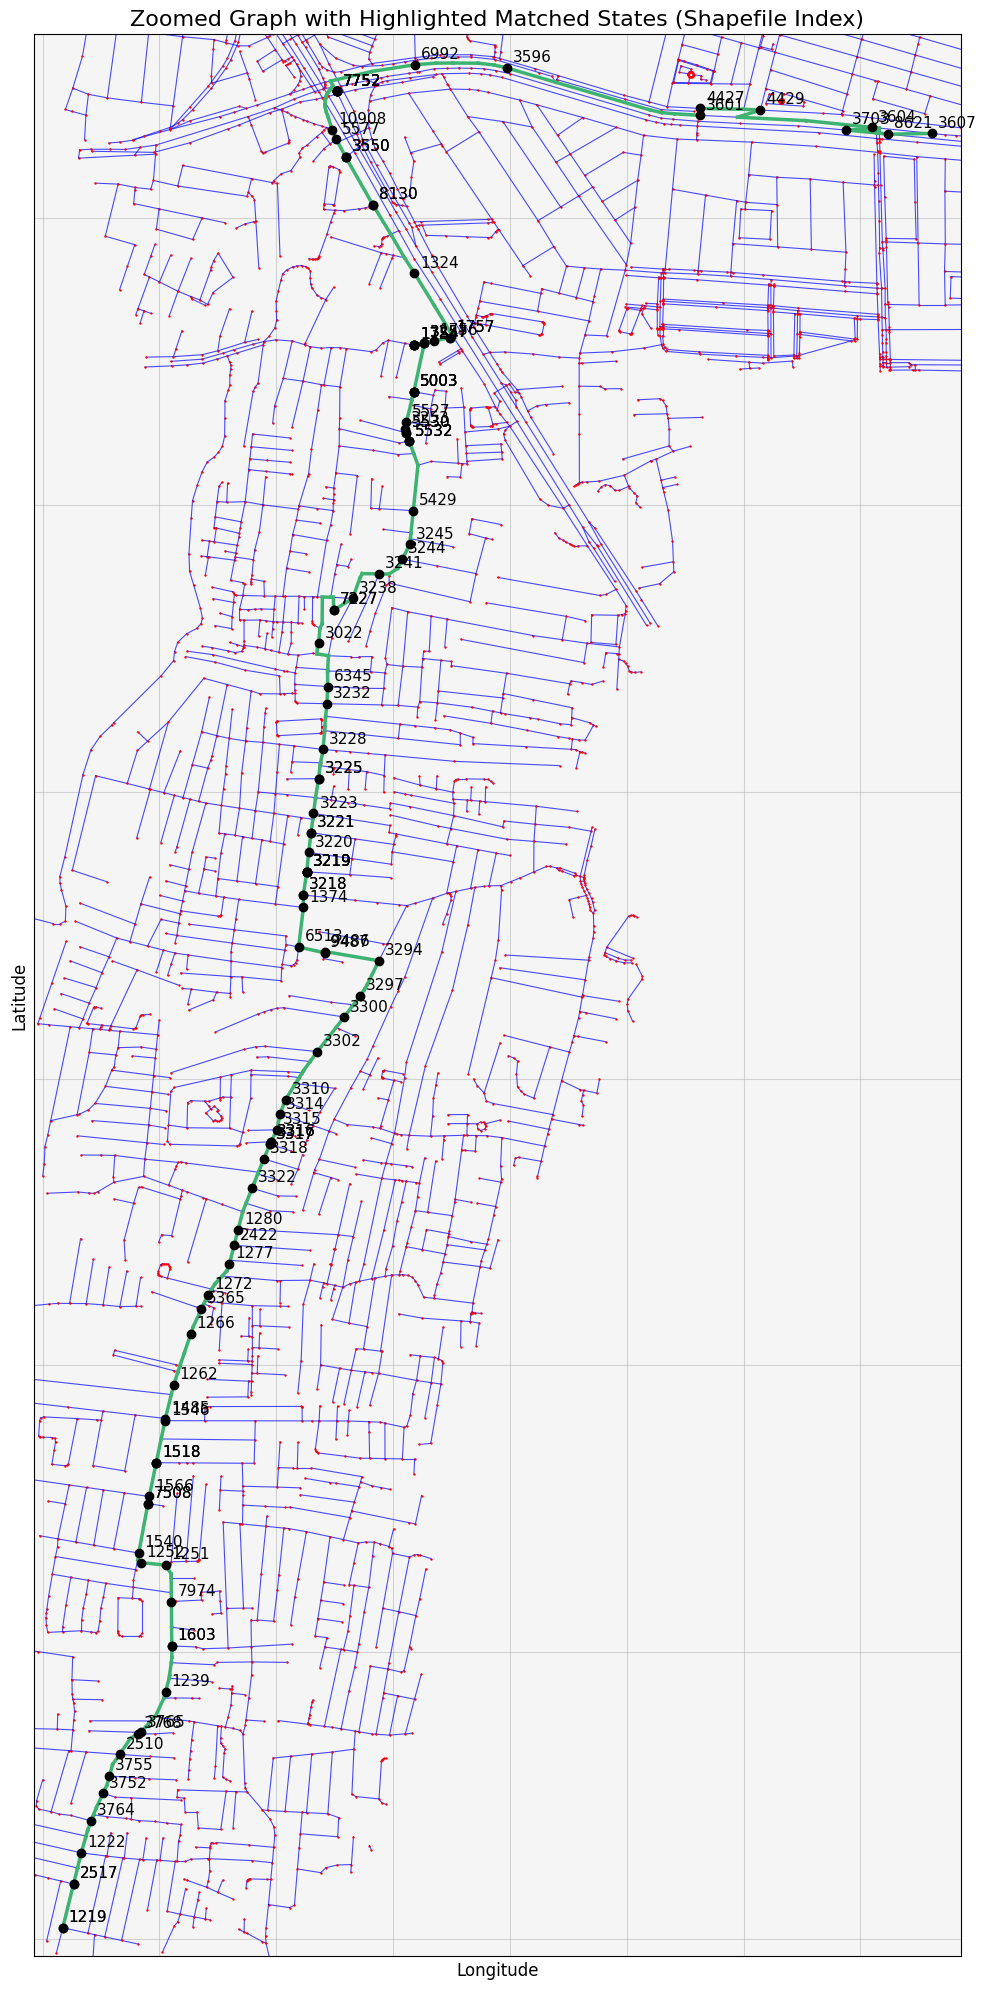

In [46]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from geopy.distance import geodesic

fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
data = gpd.read_file(fp)

G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

pos = nx.get_node_attributes(G, 'pos')

valid_highlighted_nodes_1 = [tuple(coord) for coord in matched_coordinates_1 if tuple(coord) in pos]
valid_highlighted_nodes_1 = [node for node in valid_highlighted_nodes_1 if node in pos]

def geodesic_distance(a, b):
    return geodesic(a, b).meters

def find_shortest_path_between_nodes(G, start_node, end_node):
    return nx.shortest_path(G, source=start_node, target=end_node, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))

def create_path_from_highlighted_nodes(G, nodes):
    path = [nodes[0]]
    visited = set(path)
    for i in range(len(nodes) - 1):
        segment = find_shortest_path_between_nodes(G, nodes[i], nodes[i + 1])
        for node in segment[1:]:
            if node not in visited:
                path.append(node)
                visited.add(node)
    return path

def calculate_path_segment_distances(G, nodes):
    segment_distances = []
    total_path_length = 0
    print("\n--- Path Segment Distances (Shortest Path Between Consecutive Matched States) ---")
    for i in range(len(nodes) - 1):
        segment = find_shortest_path_between_nodes(G, nodes[i], nodes[i + 1])
        distance = 0
        for j in range(len(segment) - 1):
            pt1 = segment[j]
            pt2 = segment[j + 1]
            distance += geodesic(pos[pt1], pos[pt2]).meters
        segment_distances.append(distance)
        total_path_length += distance
        print(f"Segment from state {coord_to_index[nodes[i]]} to {coord_to_index[nodes[i+1]]}: {distance:.2f} meters")
    print(f"\nTotal path length over shortest paths: {total_path_length:.2f} meters")
    return segment_distances, total_path_length

if len(valid_highlighted_nodes_1) > 2:
    path_nodes_1 = create_path_from_highlighted_nodes(G, valid_highlighted_nodes_1)
else:
    path_nodes_1 = valid_highlighted_nodes_1

segment_distances, total_path_length = calculate_path_segment_distances(G, valid_highlighted_nodes_1)

fig, ax = plt.subplots(figsize=(10, 20))

for edge in G.edges(data=True):
    line = edge[2]['geometry']
    x, y = line.xy
    ax.plot(x, y, color='blue', linewidth=0.8, alpha=0.7)

nx.draw_networkx_nodes(G, pos, ax=ax, node_size=0.5, node_color='red')

for node in valid_highlighted_nodes_1:
    x, y = node
    ax.plot(x, y, marker='o', color='black', markersize=6, zorder=3)
    idx_label = coord_to_index.get(node, 'N/A')
    ax.text(x + 0.0001, y + 0.0001, str(idx_label), fontsize=11, color='black', zorder=4)

for i in range(len(path_nodes_1) - 1):
    start = path_nodes_1[i]
    end = path_nodes_1[i + 1]
    line = LineString([Point(start), Point(end)])
    x, y = line.xy
    ax.plot(x, y, color='mediumseagreen', linewidth=2.5, linestyle='-', zorder=2)

x_coords = [coord[0] for coord in path_nodes_1]
y_coords = [coord[1] for coord in path_nodes_1]
margin = 0.0005
ax.set_xlim(min(x_coords) - margin, max(x_coords) + margin)
ax.set_ylim(min(y_coords) - margin, max(y_coords) + margin)
ax.set_facecolor('whitesmoke')
ax.tick_params(axis='both', which='major', labelsize=10)
plt.title("Zoomed Graph with Highlighted Matched States (Shapefile Index)", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


+---------------+-------------+-----------------+
|   Path Length |    Geodesic |   distance_diff |
+===============+=============+=================+
|       0       |   3.85174   |       3.85174   |
+---------------+-------------+-----------------+
|      27.5434  |  95.8554    |      68.3119    |
+---------------+-------------+-----------------+
|       0       |  22.32      |      22.32      |
+---------------+-------------+-----------------+
|      19.6289  |  41.7746    |      22.1457    |
+---------------+-------------+-----------------+
|      23.3198  |  89.6614    |      66.3416    |
+---------------+-------------+-----------------+
|      25.3762  |  42.1449    |      16.7687    |
+---------------+-------------+-----------------+
|      14.3623  |  40.2333    |      25.8709    |
+---------------+-------------+-----------------+
|      21.5965  |  37.9726    |      16.3761    |
+---------------+-------------+-----------------+
|      36.1673  |  51.7148    |      15.5475    |


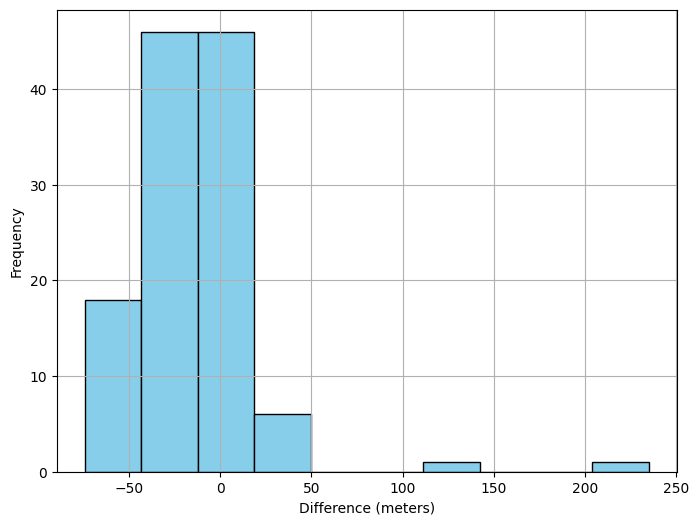

In [47]:
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

distances_1_1 = []
distances_1 = []
highlighted_distances = []
total_distance = 0

def calculate_consecutive_geodesic_distances(points, distances_list):
    total = 0
    for i in range(1, len(points)):
        distance = geodesic(points[i-1], points[i]).meters
        total += distance
        distances_list.append(distance)
    return distances_list, total

consecutive_distances_km_1, total_distance = calculate_consecutive_geodesic_distances(path_nodes_1, distances_1)

valid_highlighted_indices = [path_nodes_1.index(node) for node in valid_highlighted_nodes_1 if node in path_nodes_1]

for i in range(1, len(valid_highlighted_indices)):
    start_index, end_index = valid_highlighted_indices[i-1], valid_highlighted_indices[i]
    highlighted_distance = np.sum(distances_1[start_index:end_index])
    highlighted_distances.append(highlighted_distance)

gpx_coordinates_obs = [(lat, lon) for lon, lat in observations_1_no_duplicates]
consecutive_distances_km_1, _ = calculate_consecutive_geodesic_distances(gpx_coordinates_obs, distances_1_1)

data = []
for i in range(max(len(highlighted_distances), len(distances_1_1))):
    row = [
        highlighted_distances[i] if i < len(highlighted_distances) else "", 
        distances_1_1[i] if i < len(distances_1_1) else "", 
        abs(highlighted_distances[i] - distances_1_1[i]) if i < len(highlighted_distances) and i < len(distances_1_1) else ""
    ]
    data.append(row)

headers = ["Path Length", "Geodesic", "distance_diff"]
print(tabulate(data, headers=headers, tablefmt="grid"))

if len(highlighted_distances) == len(distances_1_1):
    plt.figure(figsize=(8, 6))
    plt.hist(np.array(highlighted_distances) - np.array(distances_1_1), bins=10, edgecolor='black', color='skyblue')
    plt.xlabel("Difference (meters)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
else:
    print("\nThe highlighted_distances and distances_1_1 arrays have different lengths. Cannot compute differences.")


In [48]:
from tabulate import tabulate
data = []
max_len = min(len(highlighted_distances), len(distances_1_1))
for i in range(max_len):
    path_length = highlighted_distances[i]
    geodesic = distances_1_1[i]
    distance_diff = abs(path_length - geodesic)

    if distance_diff > 100:
        data.append([i, path_length, geodesic, distance_diff])

print(tabulate(data, headers=["Index", "Path Length (m)", "Geodesic (m)", "Distance Diff (m)"], tablefmt="grid"))

significant_indices = [row[0] for row in data]
print("\nIndices with distance_diff > 100:")
print(significant_indices)


+---------+-------------------+----------------+---------------------+
|   Index |   Path Length (m) |   Geodesic (m) |   Distance Diff (m) |
+=========+===================+================+=====================+
|     114 |           368.754 |       133.952  |             234.801 |
+---------+-------------------+----------------+---------------------+
|     116 |           149.24  |        32.2727 |             116.968 |
+---------+-------------------+----------------+---------------------+

Indices with distance_diff > 100:
[114, 116]


Total distance of the shortest path: 3481.47 meters
Total geodesic distance : 2883.81 meters

Observation to Matched Node Mapping (within Geofence):
  Obs Index  Obs Coord (lon, lat)      Matched Node Coord          Shapefile Index
-----------  ------------------------  ------------------------  -----------------
          0  (77.6182517, 12.8850233)  (77.6183449, 12.8851927)               1219
          1  (77.6182212, 12.8850411)  (77.6183449, 12.8851927)               1219
          2  (77.6184592, 12.8858755)  (77.6185295, 12.8859558)               2517
          3  (77.6185108, 12.8860708)  (77.6185295, 12.8859558)               2517
          4  (77.6186143, 12.8864345)  (77.6186611, 12.8864994)               1222
          5  (77.6187868, 12.8872271)  (77.6188321, 12.8870555)               3764
          6  (77.6189671, 12.8875645)  (77.6190344, 12.8875367)               3752
          7  (77.6191121, 12.8878992)  (77.6191444, 12.8878398)               3755
          8  (77.6192

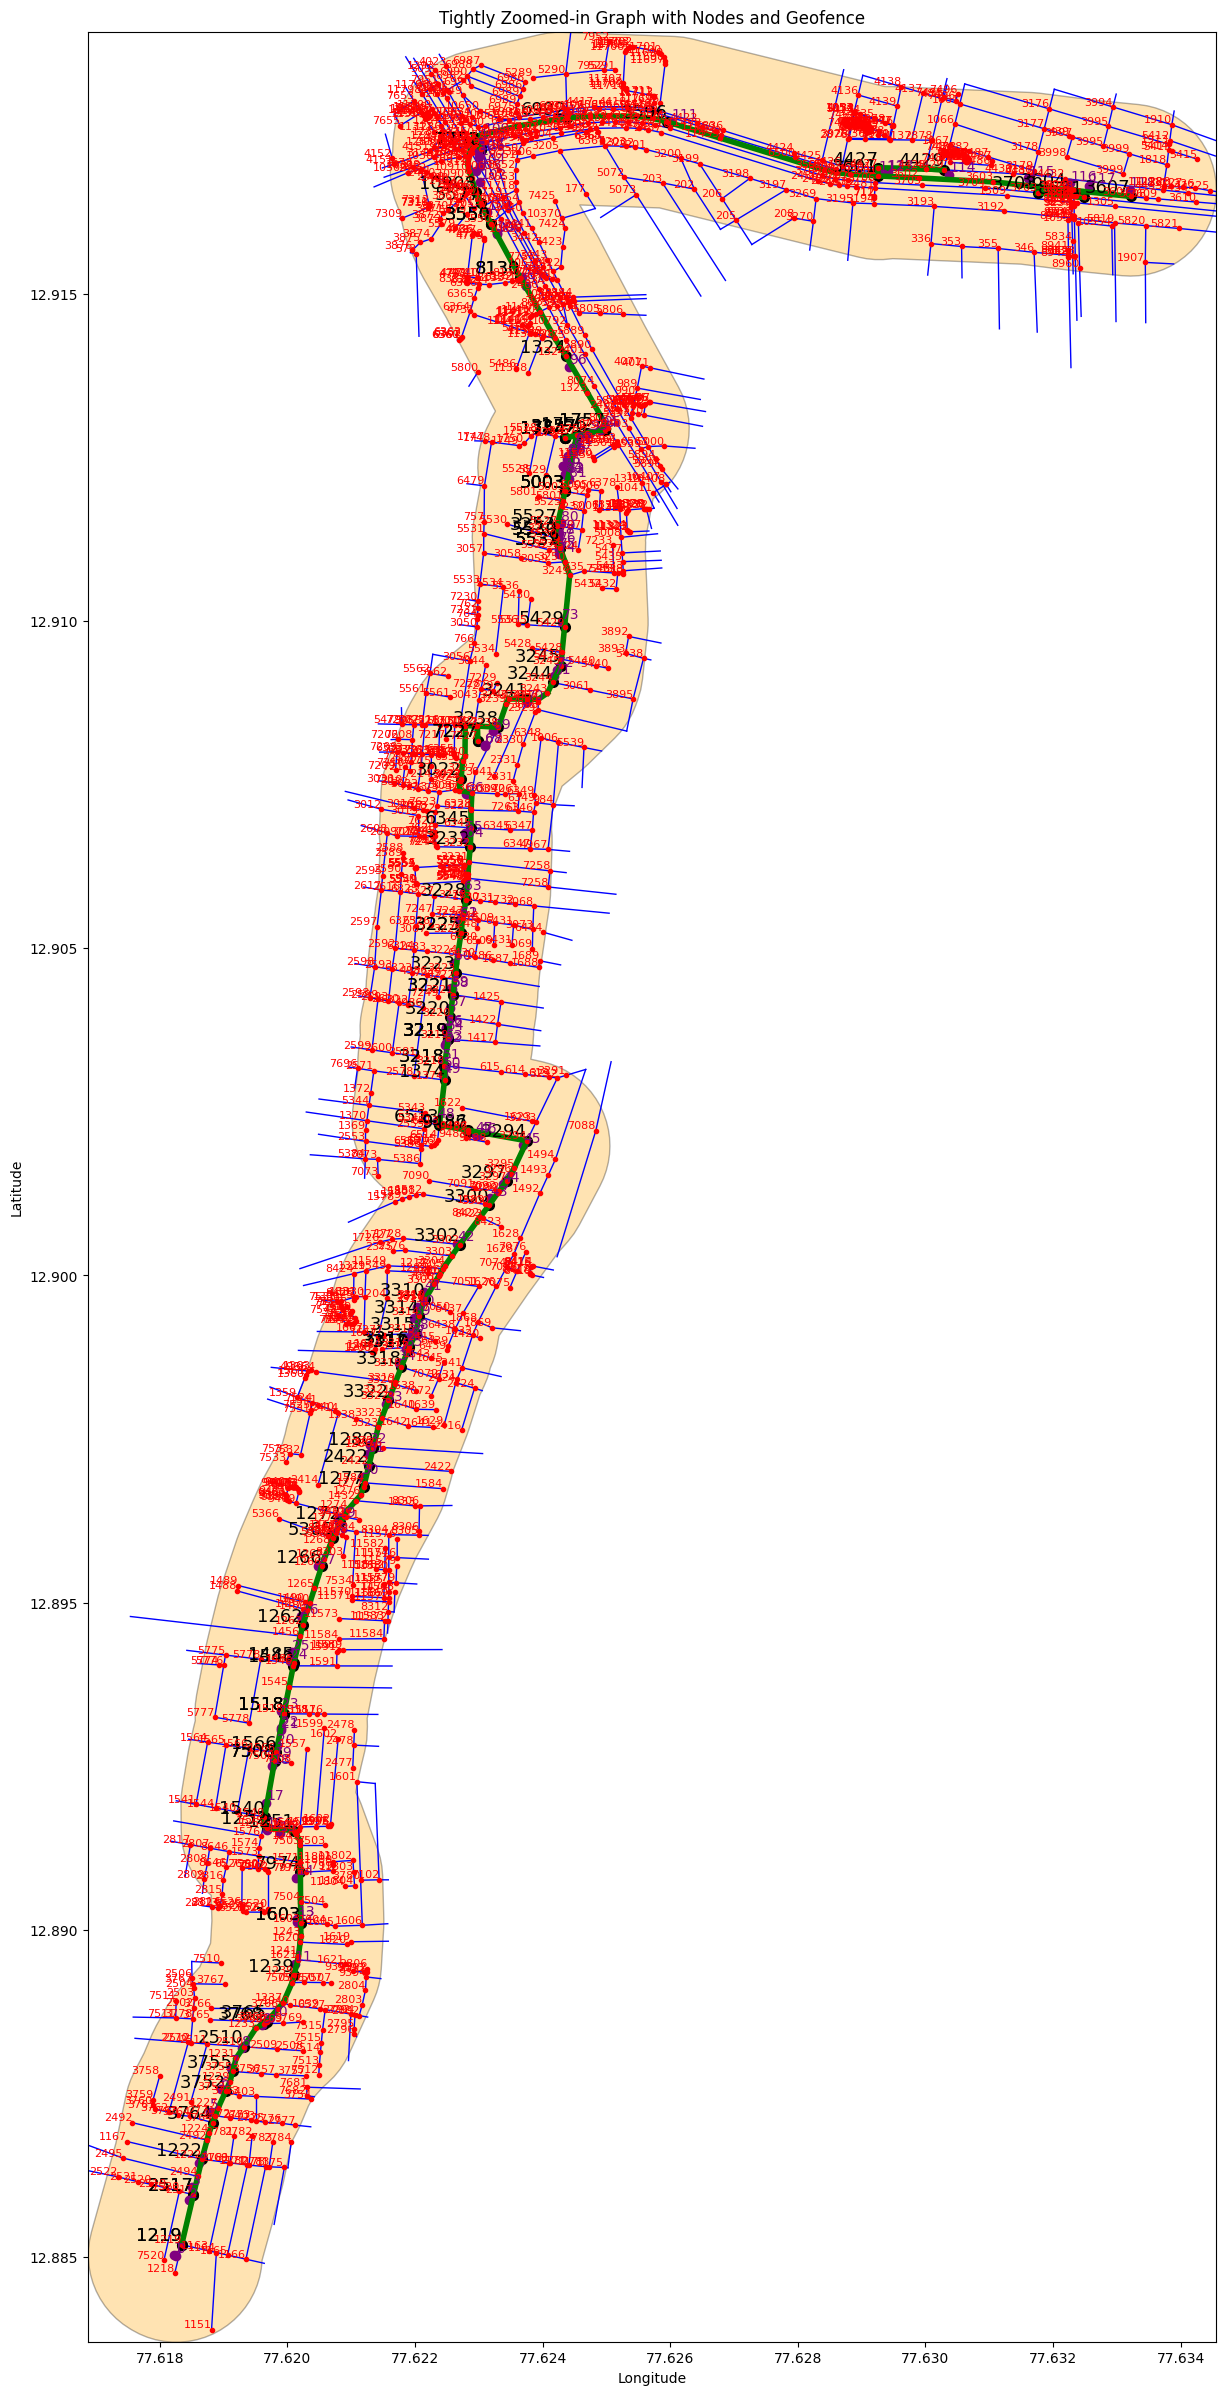

In [49]:
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
from tabulate import tabulate

fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'

data = gpd.read_file(fp)
G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index_1_1 = 0
end_index_1_1 = 150

observations_1 = [
    (point.longitude, point.latitude)
    for track in gpx.tracks
    for segment in track.segments
    for i, point in enumerate(segment.points)
    if start_index_1_1 <= i < end_index_1_1
]

observations_1_no_duplicates = [pt for i, pt in enumerate(observations_1) if i == 0 or pt != observations_1[i - 1]]

gpx_path = LineString(observations_1_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326").to_crs(epsg=3857)
geofence = gpx_gdf.buffer(150).to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if connected_components:
    subgraph_1 = G.subgraph(connected_components[0]).copy()
    pos_1 = nx.get_node_attributes(subgraph_1, 'pos')

    nodes_in_geofence = [node for node, position in pos_1.items() if geofence.geometry[0].contains(Point(position))]
    edges_in_geofence = [edge for edge in subgraph_1.edges(data=True) if geofence.geometry[0].intersects(edge[2]['geometry'])]

    def geodesic_distance(a, b):
        return geodesic(a, b).kilometers

    def shortest_path_geodesic_weight(G, source, target):
        return nx.shortest_path(G, source=source, target=target, weight=lambda u, v, d: geodesic_distance(pos_1[u], pos_1[v]))

    fig, ax = plt.subplots(figsize=(30, 30))

    for edge in edges_in_geofence:
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    valid_highlighted_nodes_1 = [tuple(coord) for coord in matched_coordinates_1 if tuple(coord) in pos_1]
    valid_nodes_in_geofence = [node for node in valid_highlighted_nodes_1 if Point(pos_1[node]).within(geofence.geometry[0])]

    for idx, node in enumerate(valid_nodes_in_geofence):
        x, y = node
        ax.plot(x, y, marker='o', color='black', markersize=7)
        node_index = coord_to_index.get((x, y), None)
        ax.text(x, y, str(node_index), fontsize=13, color='black', ha='right', va='bottom')

    for i, pt in enumerate(observations_1_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
            ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

    geofence.plot(ax=ax, color='orange', alpha=0.3, edgecolor='black')

    plotted_edges = set()
    total_shortest_path_distance = 0.0
    for i in range(len(valid_nodes_in_geofence) - 1):
        start = valid_nodes_in_geofence[i]
        end = valid_nodes_in_geofence[i + 1]
        if nx.has_path(subgraph_1, start, end):
            path = shortest_path_geodesic_weight(subgraph_1, start, end)
            segment_distance = 0.0
            for j in range(len(path) - 1):
                node_start = path[j]
                node_end = path[j + 1]
                dist = geodesic_distance(pos_1[node_start], pos_1[node_end])
                segment_distance += dist
                if (node_start, node_end) not in plotted_edges:
                    line = subgraph_1[node_start][node_end]['geometry']
                    if geofence.geometry[0].intersects(line):
                        intersected_line = line.intersection(geofence.geometry[0])
                        if isinstance(intersected_line, LineString):
                            x, y = intersected_line.xy
                            ax.plot(x, y, color='green', linewidth=4, linestyle='-')
                            plotted_edges.add((node_start, node_end))
            total_shortest_path_distance += segment_distance

    def calculate_geodesic_distance(points):
        total_distance = 0.0
        for i in range(1, len(points)):
            total_distance += geodesic(points[i - 1], points[i]).kilometers
        return total_distance

    total_observation_path_distance = calculate_geodesic_distance(observations_1_no_duplicates)
    print(f"Total distance of the shortest path: {total_shortest_path_distance * 1000:.2f} meters")
    print(f"Total geodesic distance : {total_observation_path_distance * 1000:.2f} meters")

    for node in nodes_in_geofence:
        x, y = pos_1[node]
        ax.plot(x, y, marker='o', color='red', markersize=3)
        node_index = coord_to_index.get((x, y), None)
        ax.text(x, y, str(node_index), fontsize=8, color='red', ha='right', va='bottom')

    mapping_table = []
    obs_counter = 0
    for i, pt in enumerate(observations_1_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            if obs_counter < len(valid_nodes_in_geofence):
                matched_node = valid_nodes_in_geofence[obs_counter]
                matched_index = coord_to_index.get(matched_node, "N/A")
                mapping_table.append([i, pt, matched_node, matched_index])
                obs_counter += 1

    print("\nObservation to Matched Node Mapping (within Geofence):")
    print(tabulate(mapping_table, headers=["Obs Index", "Obs Coord (lon, lat)", "Matched Node Coord", "Shapefile Index"]))

    zoom_factor = 0.000001
    minx, miny, maxx, maxy = geofence.total_bounds
    ax.set_xlim(minx - zoom_factor, maxx + zoom_factor)
    ax.set_ylim(miny - zoom_factor, maxy + zoom_factor)
    plt.title("Tightly Zoomed-in Graph with Nodes and Geofence")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


Candidate idx: 9486, Angle Difference: 2.46°, Distance Difference: 0.0253 km
Candidate idx: 9487, Angle Difference: 3.92°, Distance Difference: 0.0260 km

Top 5 candidate node numbers for observation 46: [9486, 9487]
Reassigned: original 9486 → new index: 9486, angle: 2.46°, dist: 25.30 m
Candidate idx: 7797, Angle Difference: 4.90°, Distance Difference: 0.0432 km
Candidate idx: 3717, Angle Difference: 0.99°, Distance Difference: 0.0434 km
Candidate idx: 3718, Angle Difference: 1.03°, Distance Difference: 0.0402 km
Candidate idx: 3719, Angle Difference: 1.68°, Distance Difference: 0.0234 km
Candidate idx: 3720, Angle Difference: 4.20°, Distance Difference: 0.0177 km

Top 5 candidate node numbers for observation 110: [7794, 7795, 11288, 3717, 3718]
Reassigned: original 6992 → new index: 7794, angle: 0.48°, dist: 19.48 m
Candidate idx: 2487, Angle Difference: 3.81°, Distance Difference: 0.0235 km
Candidate idx: 3201, Angle Difference: 4.76°, Distance Difference: 0.0672 km
Candidate idx: 

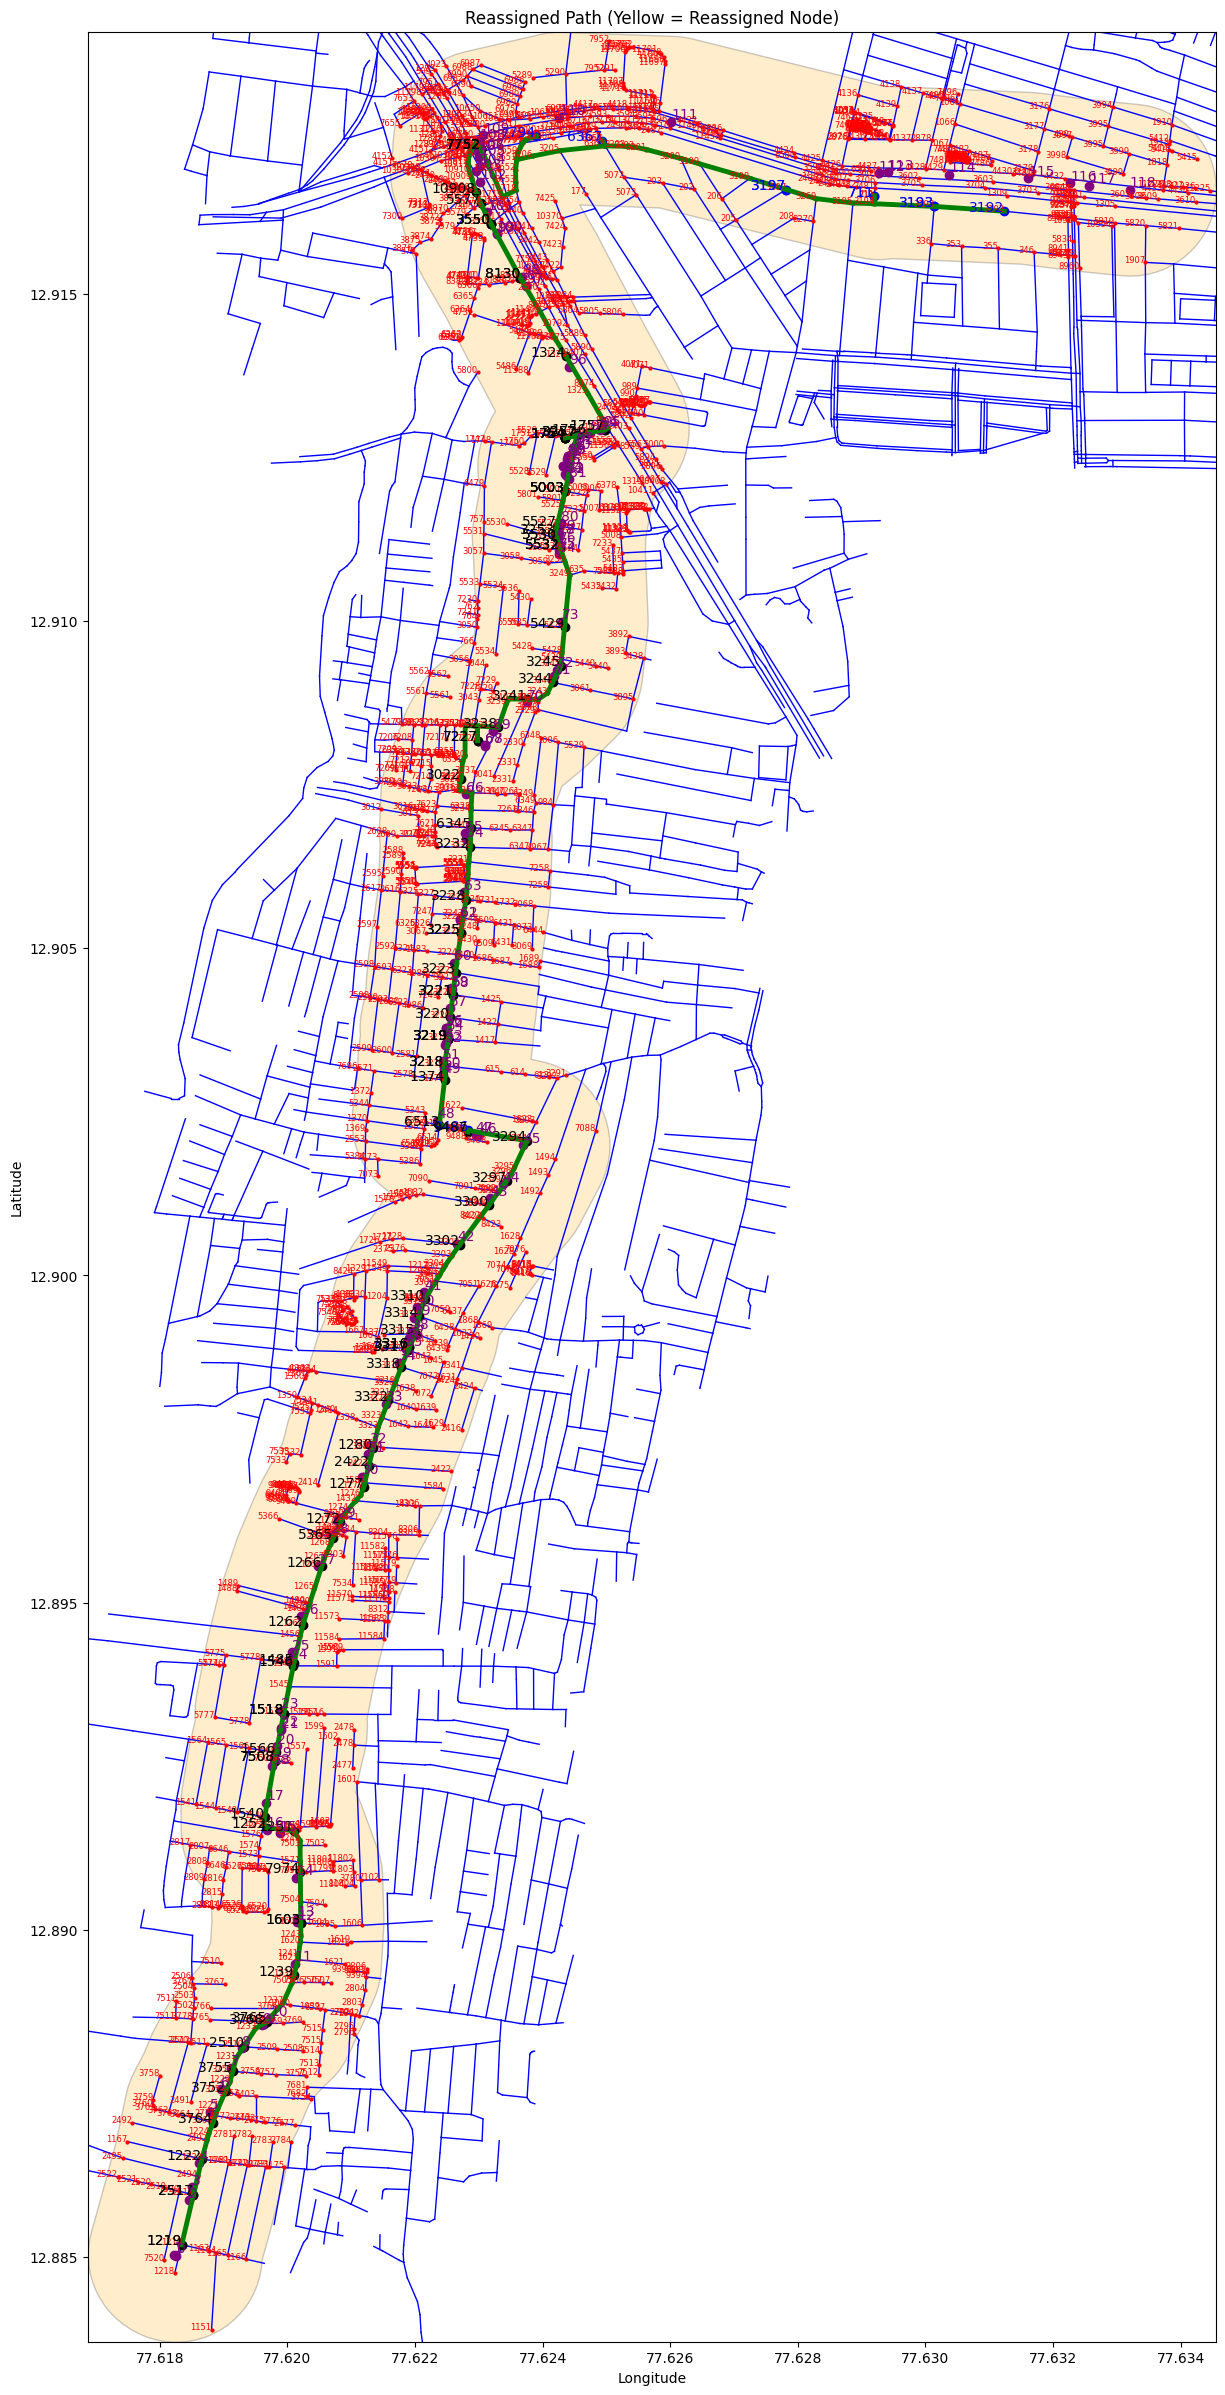

In [55]:
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
import math
import numpy as np

fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'

data = gpd.read_file(fp)
G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index = 0
end_index = 150

observations = [
    (point.longitude, point.latitude)
    for track in gpx.tracks
    for segment in track.segments
    for i, point in enumerate(segment.points)
    if start_index <= i < end_index
]

observations_1_no_duplicates = [pt for i, pt in enumerate(observations) if i == 0 or pt != observations[i - 1]]

gpx_path = LineString(observations_1_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
gpx_gdf_3857 = gpx_gdf.to_crs(epsg=3857)
geofence_buffered_3857 = gpx_gdf_3857.buffer(150)  
geofence = geofence_buffered_3857.to_crs(epsg=4326)  

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if connected_components:
    subgraph = G.subgraph(connected_components[0]).copy()
    pos = nx.get_node_attributes(subgraph, 'pos')
    states_in_geofence = [node for node in pos if geofence.geometry[0].contains(Point(pos[node]))]

    def geodesic_distance(a, b):
        return geodesic(a, b).kilometers

    def shortest_path_distance(G, source, target):
        path = nx.shortest_path(G, source, target, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))
        return path, sum(geodesic_distance(pos[path[i]], pos[path[i + 1]]) for i in range(len(path) - 1))

    def calculate_heading(p1, p2):
        lon1, lat1 = map(math.radians, p1)
        lon2, lat2 = map(math.radians, p2)
        d_lon = lon2 - lon1
        x = math.sin(d_lon) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)
        return (math.degrees(math.atan2(x, y)) + 360) % 360

    def angle_diff_signed(a, b):
        diff = (b - a + 360) % 360
        return diff - 360 if diff > 180 else diff

    def reassign_node(fixed_node, obs_heading, i):
        candidates = []
        obs_dist = geodesic(observations_1_no_duplicates[i - 1], observations_1_no_duplicates[i]).km
        for candidate in states_in_geofence:
            if not nx.has_path(subgraph, fixed_node, candidate):
                continue
            node_heading = calculate_heading(pos[fixed_node], pos[candidate])
            angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
            _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate)
            dist_difference = abs(dist_to_candidate - obs_dist)
            if angle_difference <= 5 and dist_difference <= 0.07:  
                candidates.append((angle_difference, dist_difference, candidate))
        for cand in candidates[:5]:
            print(f"Candidate idx: {coord_to_index.get(cand[2], 'N/A')}, Angle Difference: {cand[0]:.2f}°, Distance Difference: {cand[1]:.4f} km")
        if candidates:
            candidates.sort(key=lambda x: (x[0], x[1]))
            print(f"\nTop 5 candidate node numbers for observation {i}: {[coord_to_index.get(c[2], 'N/A') for c in candidates[:5]]}")
            best_candidate = candidates[0]
            return best_candidate[2], best_candidate  
        return None, None

    reassigned_nodes = [tuple(matched_coordinates_1[0])]
    reassigned_log = []
    reassignment_memory = {}

    for i in range(1, min(len(matched_coordinates_1), len(observations_1_no_duplicates))):
        fixed_node = reassigned_nodes[-1]
        target_node = tuple(matched_coordinates_1[i])
        original_index = coord_to_index.get(target_node, None)

        if original_index in reassignment_memory:
            reassigned = reassignment_memory[original_index]
            reassigned_nodes.append(reassigned)
            continue

        if fixed_node in pos and target_node in pos and nx.has_path(subgraph, fixed_node, target_node):
            _, dist = shortest_path_distance(subgraph, fixed_node, target_node)
            if dist <= 0.1:
                reassigned_nodes.append(target_node)
                continue

        obs_heading = calculate_heading(observations_1_no_duplicates[i - 1], observations_1_no_duplicates[i])
        reassigned, candidate_info = reassign_node(fixed_node, obs_heading, i)
        if reassigned:
            reassigned_nodes.append(reassigned)
            idx = coord_to_index.get(reassigned, "N/A")
            reassignment_memory[original_index] = reassigned
            print(f"Reassigned: original {original_index} → new index: {idx}, angle: {candidate_info[0]:.2f}°, dist: {candidate_info[1]*1000:.2f} m")
            reassigned_log.append((target_node, reassigned, idx, candidate_info))
        else:
            # fallback_node = fixed_node
            # best_angle_diff = float('inf')
            # for neighbor in subgraph.neighbors(fixed_node):
            #     if not nx.has_path(subgraph, fixed_node, neighbor):
            #         continue
            #     node_heading = calculate_heading(pos[fixed_node], pos[neighbor])
            #     angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
            #     if angle_difference < best_angle_diff:
            #         best_angle_diff = angle_difference
            #         fallback_node = neighbor
            # reassigned_nodes.append(fallback_node)
            # idx = coord_to_index.get(fallback_node, "N/A")
            # print(f"[OBS {i}] Fallback to neighbor: index {idx}, Node {fallback_node}, angle_diff: {best_angle_diff:.2f}°")
            reassigned_nodes.append(fixed_node)
            idx = coord_to_index.get(fixed_node, "N/A")
            print(f"[OBS {i}] Retained (fallback): index {idx}, Node {fixed_node}, Obs {observations_1_no_duplicates[i]}")

    fig, ax = plt.subplots(figsize=(30, 30))

    for edge in subgraph.edges(data=True):
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    for node in states_in_geofence:
        x, y = pos[node]
        ax.plot(x, y, marker='o', color='red', markersize=2)
        idx = coord_to_index.get((x, y), None)
        if idx is not None:
            ax.text(x, y, str(idx), fontsize=6, color='red', ha='right')

    for node in reassigned_nodes:
        if node in pos and geofence.geometry[0].contains(Point(pos[node])):
            x, y = node
            color = 'blue' if any(node == r[1] for r in reassigned_log) else 'black'
            ax.plot(x, y, marker='o', color=color, markersize=6)
            idx = coord_to_index.get((x, y), None)
            if idx is not None:
                ax.text(x, y, str(idx), fontsize=10, color=color, ha='right')

    for i, pt in enumerate(observations_1_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
            ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

    plotted_edges = set()
    print("--Segment Distances--")
    for i in range(1, len(reassigned_nodes)):
        a, b = reassigned_nodes[i - 1], reassigned_nodes[i]
        if a in pos and b in pos and nx.has_path(subgraph, a, b):
            path, d = shortest_path_distance(subgraph, a, b)
            print(f"Segment {i}: {d*1000:.2f} m")
            for j in range(len(path) - 1):
                edge_geom = subgraph[path[j]][path[j + 1]]['geometry']
                if (path[j], path[j + 1]) not in plotted_edges:
                    x, y = edge_geom.xy
                    ax.plot(x, y, color='green', linewidth=3.5)
                    plotted_edges.add((path[j], path[j + 1]))

    geofence.plot(ax=ax, color='orange', alpha=0.2, edgecolor='black')
    minx, miny, maxx, maxy = geofence.total_bounds
    ax.set_xlim(minx - 1e-6, maxx + 1e-6)
    ax.set_ylim(miny - 1e-6, maxy + 1e-6)
    plt.title("Reassigned Path (Yellow = Reassigned Node)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [56]:
from tabulate import tabulate

mapping_table = []
for i, (obs_coord, reassigned_node) in enumerate(zip(observations_1_no_duplicates, reassigned_nodes)):
    if reassigned_node in coord_to_index:
        node_index = coord_to_index[reassigned_node]
    else:
        node_index = "N/A"
    mapping_table.append([i, obs_coord, reassigned_node, node_index])

print("\nObservation to Reassigned Node Mapping Table:")
print(tabulate(mapping_table, headers=["Obs Index", "Obs Coord (lon, lat)", "Reassigned Node", "Shapefile Index"]))



Observation to Reassigned Node Mapping Table:
  Obs Index  Obs Coord (lon, lat)      Reassigned Node             Shapefile Index
-----------  ------------------------  ------------------------  -----------------
          0  (77.6182517, 12.8850233)  (77.6183449, 12.8851927)               1219
          1  (77.6182212, 12.8850411)  (77.6183449, 12.8851927)               1219
          2  (77.6184592, 12.8858755)  (77.6185295, 12.8859558)               2517
          3  (77.6185108, 12.8860708)  (77.6185295, 12.8859558)               2517
          4  (77.6186143, 12.8864345)  (77.6186611, 12.8864994)               1222
          5  (77.6187868, 12.8872271)  (77.6188321, 12.8870555)               3764
          6  (77.6189671, 12.8875645)  (77.6190344, 12.8875367)               3752
          7  (77.6191121, 12.8878992)  (77.6191444, 12.8878398)               3755
          8  (77.6192841, 12.8881981)  (77.6193169, 12.8882166)               2510
          9  (77.6196036, 12.8885449)  (

In [57]:
from tabulate import tabulate

print("\n-- Detailed Segment Distance Comparison Table --")

table_data = []
header = [
    "Obs Index",
    "Matched Index",
    "Reassigned Index",
    "Geodesic (m)",
    "Matched Path (m)",
    "Reassigned Path (m)",
    "|Matched - Geodesic| (m)",
    "|Reassigned - Geodesic| (m)"
]

total_geodesic = 0
total_matched_path = 0
total_reassigned_path = 0

for i in range(1, len(observations_1_no_duplicates)):
    obs1 = observations_1_no_duplicates[i - 1]
    obs2 = observations_1_no_duplicates[i]
    geod = geodesic(obs1, obs2).meters  

    matched1 = tuple(matched_coordinates_1[i - 1])
    matched2 = tuple(matched_coordinates_1[i])
    matched_path_len = 0
    if matched1 in pos and matched2 in pos and nx.has_path(subgraph, matched1, matched2):
        _, matched_path_len = shortest_path_distance(subgraph, matched1, matched2)
        matched_path_len *= 1000  

    reassigned1 = tuple(reassigned_nodes[i - 1])
    reassigned2 = tuple(reassigned_nodes[i])
    reassigned_path_len = 0
    if reassigned1 in pos and reassigned2 in pos and nx.has_path(subgraph, reassigned1, reassigned2):
        _, reassigned_path_len = shortest_path_distance(subgraph, reassigned1, reassigned2)
        reassigned_path_len *= 1000  

    total_geodesic += geod
    total_matched_path += matched_path_len
    total_reassigned_path += reassigned_path_len

    matched_idx = coord_to_index.get(matched2, "N/A")
    reassigned_idx = coord_to_index.get(reassigned2, "N/A")

    table_data.append([
        i,
        matched_idx,
        reassigned_idx,
        round(geod, 4),
        round(matched_path_len, 4),
        round(reassigned_path_len, 4),
        round(abs(matched_path_len - geod), 4),
        round(abs(reassigned_path_len - geod), 4)
    ])

print(tabulate(table_data, headers=header, tablefmt="rounded_grid"))

abs_error_matched = abs(total_matched_path - total_geodesic)
abs_error_reassigned = abs(total_reassigned_path - total_geodesic)
percent_error_matched = (abs_error_matched / total_geodesic) * 100
percent_error_reassigned = (abs_error_reassigned / total_geodesic) * 100

print("\n-- Total Distances and Errors --")
print(f"Total Geodesic Distance:           {round(total_geodesic, 4)} meters")
print(f"Total Matched Path Length:         {round(total_matched_path, 4)} meters")
print(f"Total Reassigned Path Length:      {round(total_reassigned_path, 4)} meters")
print(f"|Matched - Geodesic| Error:        {round(abs_error_matched, 4)} meters ({round(percent_error_matched, 2)}%)")
print(f"|Reassigned - Geodesic| Error:     {round(abs_error_reassigned, 4)} meters ({round(percent_error_reassigned, 2)}%)")



-- Detailed Segment Distance Comparison Table --
╭─────────────┬─────────────────┬────────────────────┬────────────────┬────────────────────┬───────────────────────┬────────────────────────────┬───────────────────────────────╮
│   Obs Index │   Matched Index │   Reassigned Index │   Geodesic (m) │   Matched Path (m) │   Reassigned Path (m) │   |Matched - Geodesic| (m) │   |Reassigned - Geodesic| (m) │
├─────────────┼─────────────────┼────────────────────┼────────────────┼────────────────────┼───────────────────────┼────────────────────────────┼───────────────────────────────┤
│           1 │            1219 │               1219 │         3.4317 │             0      │                0      │                     3.4317 │                        3.4317 │
├─────────────┼─────────────────┼────────────────────┼────────────────┼────────────────────┼───────────────────────┼────────────────────────────┼───────────────────────────────┤
│           2 │            2517 │               2517 │      